d:\programming\Python\image_segmentation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


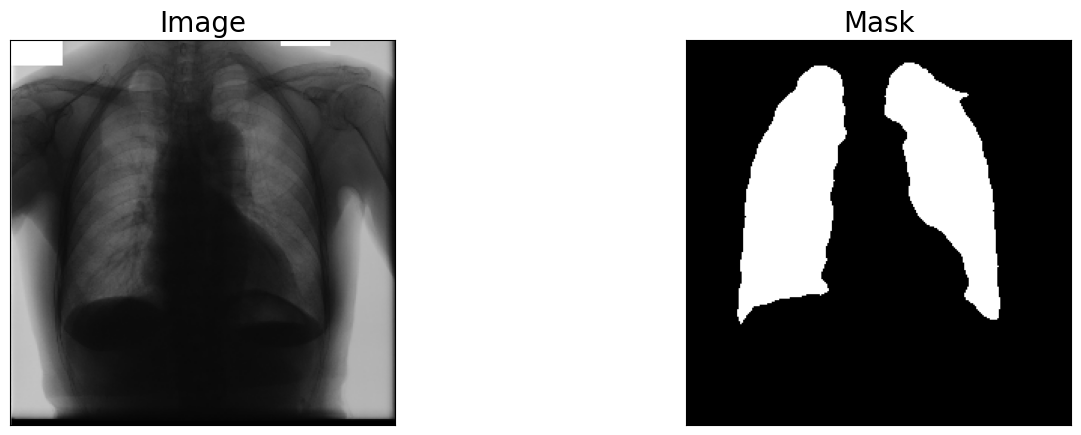

In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

import torch
import segmentation_models_pytorch as smp
from image_segmentation.train import load_params
from image_segmentation.augm import get_preprocessing
from image_segmentation.visualize import visualize


config_path = "./../model/params.yaml"
params = load_params(Path(config_path))
model_params = params.get("MODEL", {})
encoder = model_params.get("ENCODER")
encoder_weights = model_params.get("ENCODER_WEIGHTS")
classes = model_params.get("CLASSES")
model = smp.create_model(
    model_params.get("ARCHITECTURE"),
    encoder_name=encoder,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=len(classes),
)
model.load_state_dict(torch.load("./../model/best_model.pth"))
model.eval()

test_img = cv2.imread("./../data/test/img/case225.bmp")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (256, 256))

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)
input_img = preprocessing_fn(test_img)

with torch.no_grad():
    x_tensor = torch.from_numpy(input_img.transpose(2, 0, 1)).to("cpu").unsqueeze(0).float()
    pr_mask = model(x_tensor)
    pr_mask = torch.sigmoid(pr_mask)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(
        image=test_img,
        mask=pr_mask
    )